In [1]:
import numpy as np
import warnings

from convnetskeras.customlayers import Softmax4D
from keras.layers import UpSampling2D

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import obtain_input_shape
from keras.engine.topology import get_source_inputs

from keras.preprocessing import image
from convnetskeras.imagenet_tool import synset_to_dfs_ids
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
% matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5105)
/home/james/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [128]:
import os
import glob

fish_id = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
folder = '/home/james/anaconda3/data/fish/train/'

for fish in fish_id:
    k = 0
    for filename in glob.iglob(os.path.join(folder+fish, '*.jpg')):
        os.rename(filename, folder+fish+'/'+fish+str(k)+'.jpg')
        k += 1


In [340]:
folder = '/home/james/anaconda3/data/fish/test'


for filename in glob.iglob(os.path.join(folder, '*.jpg')):
    os.rename(filename, folder+'/test_stg2'+filename[len(folder):])
        


FileNotFoundError: [Errno 2] No such file or directory: '/home/james/anaconda3/data/fish/test/img_05378.jpg' -> '/home/james/anaconda3/data/fish/test/test_stg2//img_05378.jpg'

import pandas as pd
alb_df = pd.read_csv('/home/james/anaconda3/data/fish/train/ALB_loc.csv')
bet_df = pd.read_csv('/home/james/anaconda3/data/fish/train/BET_loc.csv')
dol_df = pd.read_csv('/home/james/anaconda3/data/fish/train/DOL_loc.csv')
lag_df = pd.read_csv('/home/james/anaconda3/data/fish/train/LAG_loc.csv')
yft_df = pd.read_csv('/home/james/anaconda3/data/fish/train/YFT_loc.csv')
oth_df = pd.read_csv('/home/james/anaconda3/data/fish/train/OTHER_loc.csv')
shk_df = pd.read_csv('/home/james/anaconda3/data/fish/train/SHARK_loc.csv')

import os
folder = '/home/james/anaconda3/data/fish/train/train'

for fish in os.listdir(folder):
    os.rename(folder+'/'+fish, folder+'/'+fish[:-4]+'f.jpg')

In [ ]:
alb_loc = alb_df.as_matrix()[:,1:]
bet_loc = bet_df.as_matrix()[:,1:]
dol_loc = dol_df.as_matrix()[:,1:]
lag_loc = lag_df.as_matrix()[:,1:]
yft_loc = yft_df.as_matrix()[:,1:]
oth_loc = oth_df.as_matrix()[:,1:]
shk_loc = shk_df.as_matrix()[:,1:]

vec1, vec2 = [1,3], [2,5]

in_p(dist_vec(vec1,vec2), [dist_vec(vec2,vec1)[1], dist_vec(vec1,vec2)[0]])

def dist_vec(x,y):
    return [y[0]-x[0], y[1]-x[1]]

def sum_vec(x,y):
    return [x[0]+y[0], x[1]+y[1]]

def in_p(x,y):
    return x[0]*y[0] + x[1]*y[1] 

def slope(x,y):
    dx, dy = dist_vec(x,y)[0], dist_vec(x,y)[1]
    if dx == 0:
        return 'vert'
    else:
        return dy / dx
    
def seg_box(locss, crop=True):
    if crop:
        locs = crop_box_adj(locss)
        dims = 224
    else:
        locs = locss
        dims = 256
        
    h, t = [locs[0], locs[1]], [locs[2], locs[3]]
    d, v = [locs[4], locs[5]], [locs[6], locs[7]]
    m_h, m_d = slope(h,t), slope(d,v)
    
    if m_h == 'vert':
        p_x = h[0]
        p_y = m_d*(p_x-d[0]) + d[1]
        
    elif m_d == 'vert':
        p_x = d[0]
        p_y = m_h*(p_x-h[0]) + h[1]
        
    else:
        p_x = (m_d*d[0] - m_h*h[0] + h[1] - d[1]) / (m_d - m_h)
        p_y = m_d*(p_x-d[0]) + d[1]
    
    p = [p_x, p_y]
    B = [dist_vec(p,h)[1], dist_vec(h,p)[0]]
    D_d, D_v = dist_vec(p,d), dist_vec(p,v)
    mag_min = max(abs(in_p(D_d,B)) / in_p(B,B), abs(in_p(D_v,B)) / in_p(B,B))
    C, C_n = [mag_min*B[0], mag_min*B[1]], [-mag_min*B[0], -mag_min*B[1]]
    c1, c2, c3, c4 = sum_vec(h,C), sum_vec(h,C_n), sum_vec(t,C), sum_vec(t,C_n)
    coords = [c1, c2, c3, c4]
    max_y, min_y = c1, c1
    max_x, min_x = c1, c1
    
    for k in range(4):
        if (coords[k])[1] > max_y[1]:
            max_y = coords[k]
        if (coords[k])[1] < min_y[1]:
            min_y = coords[k]
        if (coords[k])[0] > max_x[0]:
            max_x = coords[k]
        if (coords[k])[0] < min_x[0]:
            min_x = coords[k]
            
    
    region = np.zeros((dims,dims,3))
    err_d = 0.1 * mag_min
    err_h = 0.05 * np.sqrt(in_p(dist_vec(h,t),dist_vec(h,t)))
    err = max(err_d, err_h)
    if min_x[0] in [max_y[0], min_y[0]]:
        for k in range(dims):
            for j in range(dims):
                if (min_x[0] - 5 <= k) and (k <= max_x[0] + 5) and (min_y[1] -5 <= j) and (j <= max_y[1] + 5):
                    region[j,k,:] = 1
    
    else:
        
        cond1 = lambda k,j: j <= (slope(min_x,max_y)*(k - min_x[0]) + min_x[1] + err)
        cond2 = lambda k,j: j <= (slope(max_x,max_y)*(k - max_x[0]) + max_x[1] + err)
        cond3 = lambda k,j: j >= (slope(min_x,min_y)*(k - min_x[0]) + min_x[1] - err)
        cond4 = lambda k,j: j >= (slope(max_x,min_y)*(k - max_x[0]) + max_x[1] - err)
        
        for k in range(dims):
            for j in range(dims):
                if cond1(k,j) and cond2(k,j) and cond3(k,j) and cond4(k,j):
                    region[j,k,:] = 1
    
    return region


def crop_box_adj(locs):
    locs_c = np.zeros(8)
    for k in range(0,8,2):
        locs_c[k] = min(239, max(0, locs[k]-16))
    for k in range(1,8,2):
        locs_c[k] = min(239, max(0, locs[k]-16))
    return locs_c

In [278]:
# Code for a mini-batch generator to read images from disk during training
import os
from numpy import random
import PIL 
from PIL import Image

def fish_image_batch_partitioner(batch_size, fp='/home/james/anaconda3/data/fish/train', no_fish=True):
    
    bs = batch_size
    images = [image for image in os.listdir(fp) if image[-3:] in ['jpg', 'png']]
    if not no_fish:
        images = [image for image in os.listdir(fp) if image[-3:]=='jpg' and image[:3]!='NoF']
    
    for k in range(50):
        random.shuffle(images)
    
    im_part = []
    k = 0
    cur_part = []
    while images:
        if k > 0 and k%bs == 0:
            im_part.append(cur_part)
            cur_part = []
        
        im = images.pop()
        cur_part.append(im)
        k += 1
    
    return im_part

def fish_image_batch_generator(batch_partition, fp = '/home/james/anaconda3/data/fish/train/',
                              full=True, Train=True, no_fish=True, loc=False ):
    '''Batch_partition is an element of the output of fish_image_batch_partitioner.
       E.g a list of length = batch_size'''
    
    bs = len(batch_partition)
    im_batch = np.zeros((bs,224*224*3))
    im_labels = np.zeros((bs,8))
    if not no_fish:
        im_labels = np.zeros((bs,7))
    im_loc = np.zeros((bs,8))
    fish_or_not = np.zeros((bs,2))
    label_dict = {'ALB':0, 'BET':1, 'DOL':2, 'LAG':3, 'SHA':4, 'YFT':5,
                  'OTH':6, 'NoF':7}
    if not no_fish:
        label_dict = {'ALB':0, 'BET':1, 'DOL':2, 'LAG':3, 'SHA':4, 'YFT':5,
                      'OTH':6}
        
    #loc_dict = {'ALB':alb_loc, 'BET':bet_loc, 'DOL':dol_loc, 'LAG':lag_loc, 'SHA':shk_loc, 'YFT':yft_loc,
    #              'OTH':oth_loc, 'NoF':7}
    k = 0
    for fish in batch_partition:
        cur_fish = PIL.Image.open(fp + fish)

        if cur_fish.size != (256,256):
            
            cur_fish = cur_fish.resize((256,256), Image.ANTIALIAS)
            cur_fish = cur_fish.crop((15,15,239,239))
            
            im_batch[k] = (np.asarray(cur_fish,
                                  dtype='float32')).reshape((3*224**2,)) / 255
            
        else:
            cur_fish = cur_fish.crop((15,15,239,239))
     
            im_batch[k] = (np.asarray(cur_fish,
                                  dtype='float32'))[:,:,::-1].reshape((3*224**2,)) / 255
            
        if Train and not loc:
            
            im_labels[k][label_dict[fish[:3]]] = np.float32(1)
            fish_or_not[k][int(fish[:3]!='NoF')] = np.float32(1)
        
        if Train and loc:
            
            spec = fish[:3]
            num = int(''.join([x for x in fish if x.isdigit()]))
            im_loc[k] = (loc_dict[spec])[num]         
            
        cur_fish.close()
        k += 1
    if full and Train and not loc:
        return np.asarray(im_batch, dtype='float32'), np.asarray(im_labels, dtype='float32')
    elif Train and not loc:
        return np.asarray(im_batch, dtype='float32'), np.asarray(fish_or_not, dtype='float32')
    elif Train and loc:
        return np.asarray(im_batch, dtype='float32'), np.asarray(im_loc, dtype='float32') 
    else:
        return np.asarray(im_batch, dtype='float32')

In [226]:
test_part = fish_image_batch_partitioner(8,'/home/james/anaconda3/data/fish/train/segmented')

In [238]:
test_array, test_locs = fish_image_batch_generator(test_part[0],
                                                   fp = '/home/james/anaconda3/data/fish/train/segmented/')

4
4
4
4
4
4
4
4


In [235]:
3*224**2

150528

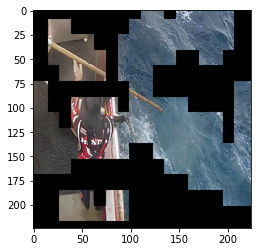

In [222]:
image_test = PIL.Image.open('/home/james/anaconda3/data/fish/train/segmented/'+test_part[0][0])
image_test = image_test.resize((256,256), Image.ANTIALIAS)
image_test = image_test.crop((15,15,239,239))
image_test.size
plt.imshow(image_test)

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection as LC
for k in range(8):
    h_x, h_y, t_x, t_y = test_locs[k,0], test_locs[k,1], test_locs[k,2], test_locs[k,3]
    d_x, d_y, v_x, v_y = test_locs[k,4], test_locs[k,5], test_locs[k,6], test_locs[k,7]
    line_loc1 = [[(h_x,h_y),(t_x,t_y)]]   # [head, tail]
    line_loc2 = [[(d_x, d_y),(v_x,v_y)]]  #  [top, bottom]
    fig = plt.figure(figsize=(10,10))
    ax=fig.add_subplot(111)
    line1 = LC(line_loc1, color='r')
    line2 = LC(line_loc2, color='r')
    #ax.add_collection(line1)
    #ax.add_collection(line2)
    plt.imshow(test_array[k].reshape((224,224,3)) * seg_box(test_locs[k]))

In [129]:
fp = '/home/james/anaconda3/data/fish/train'
fish_lists = os.listdir(fp+'/DOL') + os.listdir(fp+'/LAG')

for fish in fish_lists:
    lab = '/'+fish[:3]+'/'
    cur_fish = PIL.Image.open(fp + lab + fish)
    cur_fish = cur_fish.resize((700,700),PIL.Image.ANTIALIAS)
    
    for k in range(2):
        
        left = np.random.choice(list(range(24,75)))
        upper = np.random.choice(list(range(24,75)))
        right = 699 - (100 - left)
        lower = 699 - (100 - upper)
        cur_t = cur_fish.crop((left,upper,right,lower))
    
        cur_t.save(fp=fp+'/augmented/'+fish[:-4]+'t'+str(k)+'.jpg')
        cur_sh = cur_t.filter(PIL.ImageFilter.SHARPEN)
        cur_sh.save(fp=fp+'/augmented/'+fish[:-4]+'sh'+str(k)+'.jpg')
        cur_e = cur_t.filter(PIL.ImageFilter.EDGE_ENHANCE)
        cur_e.save(fp=fp+'/augmented/'+fish[:-4]+'e'+str(k)+'.jpg')
    cur_fish.close()

In [133]:
fp = '/home/james/anaconda3/data/fish/train'
#['BET', 'SHA']

fish_lists = os.listdir(fp+'/SHARK')

for fish in fish_lists:
    lab = '/'+'SHARK'+'/'
    cur_fish = PIL.Image.open(fp + lab + fish)
    cur_fish = cur_fish.resize((700,700),PIL.Image.ANTIALIAS)
    
    for k in range(2):
        
        left = np.random.choice(list(range(24,75)))
        upper = np.random.choice(list(range(24,75)))
        right = 699 - (100 - left)
        lower = 699 - (100 - upper)
        cur_t = cur_fish.crop((left,upper,right,lower))
    
        cur_t.save(fp=fp+'/AUG/'+fish[:-4]+'t'+str(k)+'.jpg')
        cur_sh = cur_t.filter(PIL.ImageFilter.SHARPEN)
        cur_sh.save(fp=fp+'/AUG/'+fish[:-4]+'sh'+str(k)+'.jpg')
        
    cur_fish.close()

In [137]:
fp = '/home/james/anaconda3/data/fish/train'
# ['YFT', 'NoF', 'OTH']

fish_lists = os.listdir(fp+'/YFT') + os.listdir(fp+'/OTH') + os.listdir(fp+'/NoF')
for fish in fish_lists:
    lab = '/'+fish[:3]+'/'
    cur_fish = PIL.Image.open(fp + lab + fish)
    cur_fish = cur_fish.resize((700,700),PIL.Image.ANTIALIAS)
    
    for k in range(1):
        
        left = np.random.choice(list(range(24,75)))
        upper = np.random.choice(list(range(24,75)))
        right = 699 - (100 - left)
        lower = 699 - (100 - upper)
        cur_t = cur_fish.crop((left,upper,right,lower))
    
        cur_t.save(fp=fp+'/AUG/'+fish[:-4]+'t'+str(k)+'.jpg')
        cur_sh = cur_t.filter(PIL.ImageFilter.SHARPEN)
        cur_sh.save(fp=fp+'/AUG/'+fish[:-4]+'sh'+str(k)+'.jpg')
        
    cur_fish.close()

In [ ]:
#Pre Augmentation Label Counts

counts = {'ALB':0, 'BET':0, 'DOL':0, 'LAG':0, 'SHA':0, 'YFT':0,
                  'OTH':0, 'NoF':0}

for fish in os.listdir('/home/james/anaconda3/data/fish/train'):
    if fish[-3:] == 'jpg':
        lab = fish[:3]
        counts[lab] += 1
    

In [ ]:
counts

In [3]:
# Pre-trained VGG16 Model to be converted into Fully Convolutional

def VGG16(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_dim_ordering(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    x = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
    x = Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
    x = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
    x = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
    x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
    x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
    x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
    x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = '/home/james/anaconda3/weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_dim_ordering() == 'th':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

vgg16 = VGG16(weights='imagenet', include_top=True)


layers = list(vgg16.layers)

In [4]:
# Reshape the FC Weights for Fully Conv

f_conv_w1 = [layers[20].get_weights()[0].reshape(7,7,512,4096), layers[20].get_weights()[1]]
f_conv_w2 = [layers[21].get_weights()[0].reshape(1,1,4096,4096), layers[21].get_weights()[1]]
f_conv_w3 = [layers[22].get_weights()[0].reshape(1,1,4096,1000), layers[22].get_weights()[1]]

# Create the Fully Convolutional VGG16 Model

input_img = Input((974,1280,3))

output = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1',
               weights=layers[1].get_weights())(input_img)
output = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2',
               weights=layers[2].get_weights())(output)
output = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(output)

# Block 2
output = Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1',
               weights=layers[4].get_weights())(output)
output= Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2',
              weights=layers[5].get_weights())(output)
output= MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(output)

# Block 3
output = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1',
               weights=layers[7].get_weights())(output)
output= Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2',
              weights=layers[8].get_weights())(output)
output = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3',
               weights=layers[9].get_weights())(output)
output = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(output)

# Block 4
output = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1',
               weights=layers[11].get_weights())(output)
output = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2',
               weights=layers[12].get_weights())(output)
output = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3',
               weights=layers[13].get_weights())(output)
output = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(output)

# Block 5
output= Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1',
              weights=layers[15].get_weights())(output)
output= Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2',
              weights=layers[16].get_weights())(output)
output = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3',
               weights=layers[17].get_weights())(output)
output = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(output)


# Block 6: Fully Connected to Fully Convolutional
output = Conv2D(4096, 7, 7, activation='relu', border_mode='same', name='block6_conv1',
              weights=f_conv_w1)(output)
output = Conv2D(4096, 1, 1, activation='relu', border_mode='same', name='block6_conv2',
              weights=f_conv_w2)(output)
output = Conv2D(1000, 1, 1, border_mode='same', name='block6_conv3',
              weights=f_conv_w3)(output)
output = Softmax4D(axis=1, name='softmax')(output)

model_hm = Model(input=input_img, output=output)


# Upscale Net
im_to_up = Input((30,40,1))

upscale = UpSampling2D((2,2))(im_to_up)
upscale = UpSampling2D((2,2))(upscale)
upscale = UpSampling2D((8,8))(upscale)

upscale_hm = Model(im_to_up, output=upscale)

In [246]:
img_path = '/home/james/anaconda3/data/fish/test/img_01224.jpg'

img = image.load_img(img_path, target_size=(974,1280))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

test = model_hm.predict(x)

In [247]:
s = "n02512053"
ids = synset_to_dfs_ids(s)
ids

[4, 2, 3, 5, 6, 389, 391, 390, 0, 1, 391, 392, 393, 396, 397, 394, 395]

In [248]:
heatmap = test.reshape(30,40,1000)[:,:,ids].sum(axis=2)

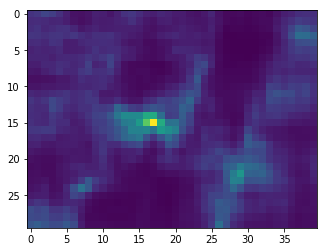

In [249]:
plt.imshow(heatmap)

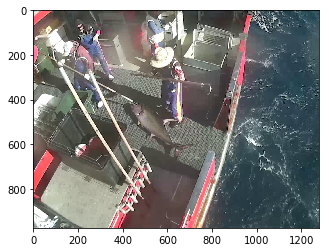

In [250]:
plt.imshow(img)

In [251]:
hm_up = upscale_hm.predict(heatmap.reshape(1,30,40,1))

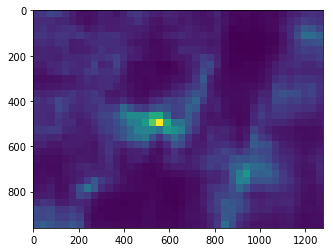

In [252]:
plt.imshow(hm_up.reshape(960,1280))

In [253]:
def neighborhood(loc, img, size=15, values=True):
    y_m, x_m = img.shape[0], img.shape[1]
    y_l = max(0, loc[1] - size)
    y_u = min(y_m, loc[1] + size)
    x_l = max(0, loc[0] - size)
    x_u = min(x_m, loc[0] + size)
    return img[y_l:y_u,x_l:x_u] if values else (y_l,y_u,x_l,x_u)
    

In [254]:
size=30

hm_fish = hm_up.reshape(960,1280)

def get_regions(size, input_img):
    M = input_img.max()
    regions = np.zeros(input_img.shape)
    for k in range(0,960-2*size,2*size):
        for j in range(0,1280-2*size,2*size):
            y_l, y_u, x_l, x_u = neighborhood((j,k),img=input_img,size=size, values=False)
            regions[y_l:y_u,x_l:x_u] = ((neighborhood((j,k),size=size,img=input_img).max() >= 0.3 * M)
                                        * np.ones((y_u - y_l, x_u - x_l)))
    return regions

regions= get_regions(30,hm_fish)

In [255]:
im_a = np.asarray(img.resize((1280,960))) / 255

for k in range(3):
    im_a[:,:,k] *= regions

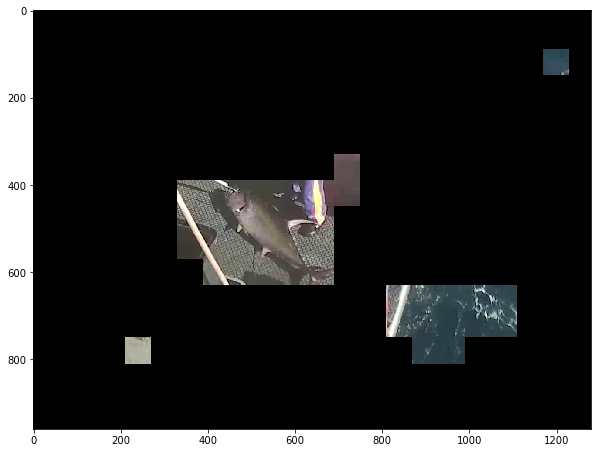

In [256]:
plt.figure(figsize=(10,10))
plt.imshow(im_a)

In [189]:
fish_id = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTH', 'SHA', 'YFT', 'AUG']
folder = '/home/james/anaconda3/data/fish/train/'

for fish in fish_id:
    
    file_list = os.listdir(folder+fish)
    
    for im in file_list:
        
        img_path = folder + fish + '/' + im

        img = image.load_img(img_path, target_size=(974,1280))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        cur_fish = model_hm.predict(x)
        
        heatmap = cur_fish.reshape(30,40,1000)[:,:,ids].sum(axis=2)
        hm_up = upscale_hm.predict(heatmap.reshape(1,30,40,1))
        
        cur_hm_fish = hm_up.reshape(960,1280) 
        regions = get_regions(30, cur_hm_fish)
        
        im_a = np.asarray(img.resize((1280,960))) / 255

        for k in range(3):
            
            im_a[:,:,k] *= regions
         
        plt.imsave(fname=folder + 'segmented/' + im[:-3]+'png', arr= im_a)

In [257]:
import os
folder = '/home/james/anaconda3/data/fish/test'

    
file_list = [file for file in os.listdir(folder) if file[-3:] == 'jpg']
    
for im in file_list:
        
    img_path = folder + '/' + im

    img = image.load_img(img_path, target_size=(974,1280))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    cur_fish = model_hm.predict(x)
        
    heatmap = cur_fish.reshape(30,40,1000)[:,:,ids].sum(axis=2)
    hm_up = upscale_hm.predict(heatmap.reshape(1,30,40,1))
        
    cur_hm_fish = hm_up.reshape(960,1280) 
    regions = get_regions(20, cur_hm_fish)
        
    im_a = np.asarray(img.resize((1280,960))) / 255

    for k in range(3):
            
        im_a[:,:,k] *= hm_fish
            
    plt.imsave(fname=folder + '/segmented/'  + im[:-3] +'png', arr= im_a)

KeyboardInterrupt: 

In [ ]:
# Block 3
output1 = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1',
               weights=layers[7].get_weights())(output1)
output1 = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2',
              weights=layers[8].get_weights())(output1)
output1 = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3',
               weights=layers[9].get_weights())(output1)
output1 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(output1)

# Block 4
output1 = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1',
               weights=layers[11].get_weights())(output1)
output1 = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2',
               weights=layers[12].get_weights())(output1)
output1 = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3',
               weights=layers[13].get_weights())(output1)
output1 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(output1)

# Block 5
output1= Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1',
              weights=layers[15].get_weights())(output1)
output1= Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2',
              weights=layers[16].get_weights())(output1)
output1 = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3',
               weights=layers[17].get_weights())(output1)
output1 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(output1)


In [290]:
from keras.layers import BatchNormalization
from keras.layers.core import Dropout



input_img1 = Input((224,224,3))

output1 = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(input_img1)
output1 = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1p')(input_img1)
output1 = BatchNormalization(axis=1)(output1)

output1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(output1)

output1 = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(output1)
output1 = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2p')(output1)
output1 = BatchNormalization(axis=1)(output1)

output1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool2')(output1)


# Block 2/3
output1 = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(output1)
output1 = BatchNormalization(axis=1)(output1)
output1 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(output1)
output1= Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(output1)
output1 = BatchNormalization(axis=1)(output1)
output1= MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool2')(output1)

#Block 4/5
output1= Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block2_conv3')(output1)
output1 = BatchNormalization(axis=1)(output1)
output1= Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block2_conv4')(output1)
output1 = BatchNormalization(axis=1)(output1)
output1= MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool3')(output1)

# FC Block


output1 = Flatten(name='flatten')(output1)
output1= Dense(2048, activation='relu', name='fc1')(output1)
output1 = BatchNormalization()(output1)
output1 = Dropout(0.45)(output1)
output1 = Dense(1024, activation='relu', name='fc2')(output1)
output1 = BatchNormalization()(output1)
output1 = Dropout(0.45)(output1)
output1 = Dense(2, activation='softmax', name='predictions')(output1)

convnet_fish_or_no = Model(input=input_img1, output = output1, name='convnet_fish_or_no')

In [274]:
input_img1 = Input((224,224,3))

output1 = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(input_img1)
output1 = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1p')(input_img1)
output1 = BatchNormalization(axis=1)(output1)

output1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(output1)

output1 = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(output1)
output1 = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2p')(output1)
output1 = BatchNormalization(axis=1)(output1)

output1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool2')(output1)


# Block 2/3
output1 = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(output1)
output1 = BatchNormalization(axis=1)(output1)
output1 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(output1)
output1= Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(output1)
output1 = BatchNormalization(axis=1)(output1)
output1= MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool2')(output1)

#Block 4/5
output1= Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block2_conv3')(output1)
output1 = BatchNormalization(axis=1)(output1)
output1= Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block2_conv4')(output1)
output1 = BatchNormalization(axis=1)(output1)
output1= MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool3')(output1)

# FC Block


output1 = Flatten(name='flatten')(output1)
output1= Dense(2048, activation='relu', name='fc1')(output1)
output1 = BatchNormalization()(output1)
output1 = Dropout(0.45)(output1)
output1 = Dense(1024, activation='relu', name='fc2')(output1)
output1 = BatchNormalization()(output1)
output1 = Dropout(0.45)(output1)
output1 = Dense(7, activation='softmax', name='predictions')(output1)

convnet_fish = Model(input=input_img1, output = output1, name='convnet_fish')

In [375]:
input_imgf = Input((224,224,3))

output = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1',
               weights=layers[1].get_weights(),trainable=False)(input_imgf)

#output = BatchNormalization(axis=1)(output)

output = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2',
               weights=layers[2].get_weights(),trainable=False )(output)

#output = BatchNormalization(axis=1)(output)

output = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(output)

# Block 2
output = Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1',
               weights=layers[4].get_weights(),trainable=False)(output)

#output = BatchNormalization(axis=1)(output)

output= Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2',
              weights=layers[5].get_weights(),trainable=False)(output)

#output = BatchNormalization(axis=1)(output)

output= MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(output)

# Block 3
output = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1',
               weights=layers[7].get_weights(),trainable=False)(output)

#output = BatchNormalization(axis=1)(output)

output= Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2',
              weights=layers[8].get_weights(),trainable=False)(output)

#output = BatchNormalization(axis=1)(output)

output = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3',
               weights=layers[9].get_weights(),trainable=False)(output)

#output = BatchNormalization(axis=1)(output)

output = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(output)

# Block 4
output = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1',
               weights=layers[11].get_weights(),trainable=False)(output)
#output = BatchNormalization(axis=1)(output)

output = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2',
               weights=layers[12].get_weights(),trainable=False)(output)
#output = BatchNormalization(axis=1)(output)

output = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3',
               weights=layers[13].get_weights(),trainable=False)(output)
#output = BatchNormalization(axis=1)(output)

output = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(output)

# Block 5
output= Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1',
              weights=layers[15].get_weights())(output)
output = BatchNormalization(axis=1)(output)

output= Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2',
              weights=layers[16].get_weights())(output)
output = BatchNormalization(axis=1)(output)

output = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3',
               weights=layers[17].get_weights())(output)
output = BatchNormalization(axis=1)(output)

output = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(output)

# FC Block


output1 = Flatten(name='flatten')(output)
output1= Dense(4096, activation='relu', name='fc1', weights=layers[20].get_weights())(output1)
output1 = BatchNormalization()(output1)
output1 = Dropout(0.65)(output1)
output1 = Dense(4096, activation='relu', name='fc2', weights=layers[21].get_weights())(output1)
output1 = BatchNormalization()(output1)
output1 = Dropout(0.65)(output1)
output1 = Dense(7, activation='softmax', name='predictions')(output1)

vgg16_fish = Model(input=input_imgf, output=output1)

In [382]:
from keras.optimizers import adam

sgd = adam(lr=0.00001)

convnet_fish_or_no.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [292]:
# Training
train_path = '/home/james/anaconda3/data/fish/train'

epoch = 1

while epoch <= 9:
    
    train_batch = fish_image_batch_partitioner(batch_size=32, fp=train_path)
    
    for part in train_batch:
        vb = int(train_batch.index(part) % 25 == 0)
        X, y = fish_image_batch_generator(part,fp=train_path + '/',full=False)
        X = X.reshape((32,224,224,3))
        convnet_fish_or_no.fit(X,y,batch_size=32,nb_epoch=1, verbose=vb)
        if vb == 1:
            print(epoch)
    epoch += 1
        

Epoch 1/1
32/32 [==============================] - 0s - loss: 1.6277 - acc: 0.2500
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.6746 - acc: 0.7812
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.5907 - acc: 0.8125
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.4425 - acc: 0.8438
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.3333 - acc: 0.8438
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.3580 - acc: 0.8750
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.5071 - acc: 0.9062
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.3861 - acc: 0.8438
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.6723 - acc: 0.7500
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.6745 - acc: 0.8438
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.1958 - acc: 0.9062
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.1

32/32 [==============================] - 0s - loss: 0.0239 - acc: 1.0000
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0952 - acc: 0.9688
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0765 - acc: 0.9375
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0053 - acc: 1.0000
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0501 - acc: 0.9688
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.1948 - acc: 0.9375
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.2370 - acc: 0.9688
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0181 - acc: 1.0000
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0096 - acc: 1.0000
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0125 - acc: 1.0000
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0472 - acc: 0.9688
9
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0065 - acc:

In [376]:
sgd = adam(lr=0.0001)
vgg16_fish.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [377]:
# Training
train_path = '/home/james/anaconda3/data/fish/train'

epoch = 1

while epoch <= 15:
    
    train_batch = fish_image_batch_partitioner(batch_size=32, fp=train_path, no_fish=False)
    
    for part in train_batch:
        vb = int(train_batch.index(part) % 25 == 0)
        X, y = fish_image_batch_generator(part,fp=train_path + '/', no_fish=False)
        X = X.reshape((32,224,224,3))
        vgg16_fish.fit(X,y,batch_size=32,nb_epoch=1, verbose=vb)
        if vb == 1:
            print(epoch)
    epoch += 1
        

Epoch 1/1
32/32 [==============================] - 0s - loss: 3.6249 - acc: 0.1250
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 1.8421 - acc: 0.5938
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 2.3951 - acc: 0.4688
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 1.4918 - acc: 0.7500
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.6695 - acc: 0.8125
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.5087 - acc: 0.8125
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.3667 - acc: 0.8438
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.4584 - acc: 0.8750
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.5093 - acc: 0.8750
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.1719 - acc: 0.9375
1
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0163 - acc: 1.0000
2
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.5

32/32 [==============================] - 0s - loss: 6.8810e-06 - acc: 1.0000
10
Epoch 1/1
32/32 [==============================] - 0s - loss: 2.7404e-05 - acc: 1.0000
10
Epoch 1/1
32/32 [==============================] - 0s - loss: 2.2496e-05 - acc: 1.0000
10
Epoch 1/1
32/32 [==============================] - 0s - loss: 2.1982e-04 - acc: 1.0000
10
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0127 - acc: 1.0000
10
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.3710 - acc: 0.9375
11
Epoch 1/1
32/32 [==============================] - 0s - loss: 9.4995e-07 - acc: 1.0000
11
Epoch 1/1
32/32 [==============================] - 0s - loss: 2.8182e-06 - acc: 1.0000
11
Epoch 1/1
32/32 [==============================] - 0s - loss: 1.0342e-04 - acc: 1.0000
11
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0144 - acc: 1.0000
11
Epoch 1/1
32/32 [==============================] - 0s - loss: 0.0821 - acc: 0.9688
11
Epoch 1/1
32/32 [===================

In [346]:
test_list1 =  [x for x in os.listdir('/home/james/anaconda3/data/fish/test_stg1') if x[-3:] == 'jpg']
test_list1p = ['test_stg2/'+ x for x in os.listdir('/home/james/anaconda3/data/fish/test_stg2') 
               if x[-3:] == 'jpg']

test_list1.sort()
test_list1p.sort()


results1 = np.zeros((1000,2))
results1p = np.zeros((12153,2))

for k in range(0,1000-32,32):
    
    test_ims1 = fish_image_batch_generator(test_list1[k:k+32], 
                                          fp='/home/james/anaconda3/data/fish/test_stg1/',
                                          Train=False)
  
    results1[k:k+32] = convnet_fish_or_no.predict(test_ims1.reshape(32,224,224,3))

final_ims1 = fish_image_batch_generator(test_list1[-32:], 
                                          fp='/home/james/anaconda3/data/fish/test_stg1/',
                                          Train=False)
results1[-32:] = convnet_fish_or_no.predict(final_ims1.reshape(32,224,224,3))


for k in range(0,12153-32,32):
    
    test_ims1p = fish_image_batch_generator(test_list1p[k:k+32], 
                                          fp='/home/james/anaconda3/data/fish/',
                                          Train=False)
  
    results1p[k:k+32] = convnet_fish_or_no.predict(test_ims1p.reshape(32,224,224,3))

final_ims1p = fish_image_batch_generator(test_list1p[-32:], 
                                          fp='/home/james/anaconda3/data/fish/',
                                          Train=False)
results1p[-32:] = convnet_fish_or_no.predict(final_ims1p.reshape(32,224,224,3))

In [378]:
test_list2 =  [x for x in os.listdir('/home/james/anaconda3/data/fish/test_stg1') if x[-3:] == 'jpg']
test_list2p = ['test_stg2/'+ x for x in os.listdir('/home/james/anaconda3/data/fish/test_stg2') 
               if x[-3:] == 'jpg']

test_list2.sort()
test_list2p.sort()


results2 = np.zeros((1000,7))
results2p = np.zeros((12153,7))

for k in range(0,1000-32,32):
    
    test_ims2 = fish_image_batch_generator(test_list2[k:k+32], 
                                          fp='/home/james/anaconda3/data/fish/test_stg1/',
                                          Train=False)
  
    results2[k:k+32] = vgg16_fish.predict(test_ims2.reshape(32,224,224,3))

final_ims2 = fish_image_batch_generator(test_list2[-32:], 
                                          fp='/home/james/anaconda3/data/fish/test_stg1/',
                                          Train=False)
results2[-32:] = vgg16_fish.predict(final_ims2.reshape(32,224,224,3))


for k in range(0,12153-32,32):
    
    test_ims2p = fish_image_batch_generator(test_list2p[k:k+32], 
                                          fp='/home/james/anaconda3/data/fish/',
                                          Train=False)
  
    results2p[k:k+32] = vgg16_fish.predict(test_ims2p.reshape(32,224,224,3))

final_ims2p = fish_image_batch_generator(test_list2p[-32:], 
                                          fp='/home/james/anaconda3/data/fish/',
                                          Train=False)
results2p[-32:] = vgg16_fish.predict(final_ims2p.reshape(32,224,224,3))

In [379]:
res2_df = pd.DataFrame(results2)
res2_df.index = test_list2
res2_df.columns = ['ALB', 'BET', 'DOL', 'LAG','SHARK', 'YFT', 'OTHER']
res2_df['NoF'] = np.ones(1000)
res2p_df = pd.DataFrame(results2p)
res2p_df.index = test_list2p
res2p_df.columns = ['ALB', 'BET', 'DOL', 'LAG','SHARK', 'YFT', 'OTHER']
res2p_df['NoF'] = np.ones(12153)

res2c_df = pd.concat([res2_df,res2p_df],ignore_index=True)

res_df = pd.DataFrame(results1)
res_df.index = test_list1
res_df.columns = ['NoF', 'Fish']

resp_df = pd.DataFrame(results1p)
resp_df.index = test_list1p
resp_df.columns = ['NoF', 'Fish']


resc_df = pd.concat([res_df,resp_df], ignore_index=True)

res_aug = res2c_df.as_matrix()
res_aug[:,-1] *= resc_df.as_matrix()[:,0]
for k in range(7):
    res_aug[:,k] *= resc_df.as_matrix()[:,1]
    
for k in range(13153):
    for j in range(8):
        if res_aug[k,j] < 0.05:
            res_aug[k,j] += 0.05
        if res_aug[k,j] > 0.95:
            res_aug[k,j] -= 0.05
            
res3_df = pd.DataFrame(res_aug)
res3_df.columns = ['ALB', 'BET', 'DOL', 'LAG','SHARK', 'YFT', 'OTHER', 'NoF']
res3_df.index = test_list1+test_list1p

In [380]:
res3_df[:50]

,ALB,BET,DOL,LAG,SHARK,YFT,OTHER,NoF
img_00005.jpg,0.051234,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.948766
img_00007.jpg,0.949809,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050191
img_00009.jpg,0.949736,0.050003,0.050000,0.050000,0.050000,0.050000,0.050000,0.050261
img_00018.jpg,0.948787,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.051213
img_00027.jpg,0.054304,0.050745,0.050016,0.050000,0.050007,0.050000,0.944925,0.050002
img_00030.jpg,0.921380,0.050000,0.050000,0.050000,0.050000,0.050000,0.050003,0.078617
img_00040.jpg,0.062153,0.050001,0.051741,0.050000,0.889974,0.050001,0.096030,0.050100
img_00046.jpg,0.937477,0.050000,0.050000,0.050000,0.050000,0.050000,0.050003,0.062519
img_00053.jpg,0.937552,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.062448
img_00071.jpg,0.938690,0.050000,0.050000,0.050000,0.050000,0.050000,0.050002,0.061308


In [381]:
res3_df.to_csv('/home/james/anaconda3/data/fish/fishnores4.csv')